## SOTA Analysis:
* Perform string matching to find SOTA repositories, if any
* Filter by ML terminology if necessary to separate ML repositories
* Inspect ML repositories and observe any SOTA-claiming repos
* If any, label them as 1 - 'SOTA', others 0 - 'Non-SOTA' within a random sampling procedure.
* Regression problem ------> Classification problem! Same features, different task.

In [1]:
# Basic utilities and data handling
import numpy as np
import pandas as pd
from tqdm import tqdm

# Machine Learning frameworks and utilities
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Deep Learning
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

# PyTorch for NLP and general operations
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel

# Statistical testing and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib.backends.backend_pdf import PdfPages

# Distance metrics and model interpretation
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
import shap

# Gradient Boosting
from xgboost import XGBClassifier

In [107]:
df = pd.read_csv('./datasets/second_dataset.csv')
df.head(20)

,owner,name,stars,forks,watchers,primaryLanguage,description,diskUsageKb,pullRequests,issues,defaultBranchCommitCount,age
0,freeCodeCamp,freeCodeCamp,371122,33158,8446,TypeScript,freeCodeCamp.org's open-source codebase and cu...,372202,33649,17010,33585.0,8.65
1,EbookFoundation,free-programming-books,295895,56913,9733,NaN,:books: Freely available programming books,17038,8392,957,8386.0,9.85
2,996icu,996.ICU,267804,21532,4242,NaN,Repo for counting stars and contributing. Pres...,187799,1962,0,3195.0,4.22
3,sindresorhus,awesome,265809,26349,7549,NaN,😎 Awesome lists about all kinds of interesting...,1441,1943,331,1103.0,9.10
4,jwasham,coding-interview-university,263430,69043,8604,NaN,A complete computer science study plan to beco...,20963,902,402,2372.0,7.17
5,public-apis,public-apis,252370,28947,3897,Python,A collective list of free APIs,4948,3016,502,4527.0,7.40
6,kamranahmedse,developer-roadmap,247233,34594,6828,TypeScript,"Interactive roadmaps, guides and other educati...",2089597,2506,1334,3633.0,6.42
7,donnemartin,system-design-primer,227201,40141,6519,Python,Learn how to design large-scale systems. Prep ...,11187,493,258,329.0,6.44
8,codecrafters-io,build-your-own-x,213075,20782,4562,NaN,Master programming by recreating your favorite...,990,331,560,528.0,5.25
9,facebook,react,211912,44446,6659,JavaScript,The library for web and native user interfaces,337423,13799,12395,15900.0,10.23


In [109]:
len(df)

3274587

In [111]:
# Convert days to years
df_years = df.copy()
df_years

,owner,name,stars,forks,watchers,primaryLanguage,description,diskUsageKb,pullRequests,issues,defaultBranchCommitCount,age
0,freeCodeCamp,freeCodeCamp,371122,33158,8446,TypeScript,freeCodeCamp.org's open-source codebase and cu...,372202,33649,17010,33585.0,8.65
1,EbookFoundation,free-programming-books,295895,56913,9733,NaN,:books: Freely available programming books,17038,8392,957,8386.0,9.85
2,996icu,996.ICU,267804,21532,4242,NaN,Repo for counting stars and contributing. Pres...,187799,1962,0,3195.0,4.22
3,sindresorhus,awesome,265809,26349,7549,NaN,😎 Awesome lists about all kinds of interesting...,1441,1943,331,1103.0,9.10
4,jwasham,coding-interview-university,263430,69043,8604,NaN,A complete computer science study plan to beco...,20963,902,402,2372.0,7.17
...,...,...,...,...,...,...,...,...,...,...,...,...
3274582,xutianyi1999,mutsuki,5,3,1,Rust,Socks5/HTTP proxy server,93,0,1,34.0,2.16
3274583,dickwyn,cip-2021,5,0,2,NaN,My slides for Code in Place sections,13561,0,0,4.0,0.02
3274584,acend,terraform-training,5,1,4,HCL,NaN,2873,257,7,564.0,2.29
3274585,suryafaktaTV,suryaTVplay,5,2,1,NaN,All Channel,683,0,0,284.0,1.82


In [112]:
# Assuming df_years is your original DataFrame

# Step 1: Create a copy of the entire DataFrame to avoid modifying the original data
filtered_df = df_years.copy()

# Step 2: Apply np.log1p to the specified columns in the copy
columns_to_transform = ['diskUsageKb', 'age', 'stars', 'forks', 'issues',\
                        'watchers', 'pullRequests', 'defaultBranchCommitCount']
filtered_df[columns_to_transform] = filtered_df[columns_to_transform].apply(np.log1p)

KeyError: "None of [Index(['repo_size', 'repo_age', 'repo_stargazers_count', 'repo_forks_count',\n       'repo_open_issues'],\n      dtype='object')] are in the [columns]"

## NLP: Computing similarity between phrase and repo description
* **Similarity Computation:**
  * **Embedding Extraction:** Convert phrases from machine learning papers and descriptions of GitHub repositories into vector embeddings using a pre-trained language model.
  * **Cosine Similarity:** Compute the cosine similarity between embeddings of phrases and repository descriptions to quantify their semantic similarity.
  * **Threshold Determination:** Establish a similarity threshold to identify significant matches, facilitating a focused analysis of related repositories.

In [113]:
# Load model and tokenizer
model_name = "sentence-transformers/all-mpnet-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

ml_ai_dl_phrases = [
    "machine learning", "machine-learning", "ML", "artificial intelligence",
    "artificial-intelligence", "AI", "deep learning", "deep-learning", "DL",
    "neural networks", "neural-networks", "NN", "computer vision", "computer-vision",
    "CV", "natural language processing", "natural-language-processing", "NLP",
    "reinforcement learning", "reinforcement-learning", "RL", "generative adversarial network",
    "generative-adversarial-network", "GAN", "predictive analytics", "predictive-modeling",
    "data science", "data-science", "DS", "algorithm development", "algorithm-development",
    "intelligent systems", "intelligent-systems", "automated reasoning", "data mining",
    "data-mining", "DM", "image recognition", "image-recognition", "speech recognition",
    "speech-recognition", "text analytics", "text-analytics", "predictive modelling",
    "predictive-modelling", "robotics", "autonomous systems", "autonomous-systems",
    "semantic analysis", "semantic-analysis", "machine perception", "machine-perception",
    "cognitive computing", "cognitive-computing", "analytics", "DNN", 'analysis', 'statistics'
]

In [115]:
# Filter out rows with "No description" or not useful descriptions
filtered_df = filtered_df[filtered_df['description'].str.strip().replace("No description", "").replace("", None).notna()]
filtered_df.head(20)

,owner,name,stars,forks,watchers,primaryLanguage,description,diskUsageKb,pullRequests,issues,defaultBranchCommitCount,age
0,freeCodeCamp,freeCodeCamp,371122,33158,8446,TypeScript,freeCodeCamp.org's open-source codebase and cu...,372202,33649,17010,33585.0,8.65
1,EbookFoundation,free-programming-books,295895,56913,9733,NaN,:books: Freely available programming books,17038,8392,957,8386.0,9.85
2,996icu,996.ICU,267804,21532,4242,NaN,Repo for counting stars and contributing. Pres...,187799,1962,0,3195.0,4.22
3,sindresorhus,awesome,265809,26349,7549,NaN,😎 Awesome lists about all kinds of interesting...,1441,1943,331,1103.0,9.10
4,jwasham,coding-interview-university,263430,69043,8604,NaN,A complete computer science study plan to beco...,20963,902,402,2372.0,7.17
5,public-apis,public-apis,252370,28947,3897,Python,A collective list of free APIs,4948,3016,502,4527.0,7.40
6,kamranahmedse,developer-roadmap,247233,34594,6828,TypeScript,"Interactive roadmaps, guides and other educati...",2089597,2506,1334,3633.0,6.42
7,donnemartin,system-design-primer,227201,40141,6519,Python,Learn how to design large-scale systems. Prep ...,11187,493,258,329.0,6.44
8,codecrafters-io,build-your-own-x,213075,20782,4562,NaN,Master programming by recreating your favorite...,990,331,560,528.0,5.25
9,facebook,react,211912,44446,6659,JavaScript,The library for web and native user interfaces,337423,13799,12395,15900.0,10.23


In [116]:
# Define dataset for DataLoader
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

In [117]:
# Function to convert texts into embeddings
def get_embeddings(texts):
    dataloader = DataLoader(TextDataset(texts), batch_size=512)
    embeddings = []
    for batch in dataloader:
        encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            model_output = model(**encoded_input)
        batch_embeddings = model_output.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings)
    return torch.cat(embeddings, dim=0)

# Calculate embeddings for ML phrases
ml_embeddings = get_embeddings(ml_ai_dl_phrases)

In [119]:
print(f"ML Embeddings: {ml_embeddings}")

ML Embeddings: tensor([[-0.1090,  0.1871, -0.1832,  ...,  0.1148,  0.0229,  0.0541],
        [-0.0865,  0.1986, -0.1869,  ...,  0.0766,  0.0734,  0.0119],
        [-0.0310,  0.1741, -0.0890,  ...,  0.0314, -0.0454, -0.0494],
        ...,
        [-0.1573,  0.1449, -0.0793,  ...,  0.0418, -0.0019, -0.0594],
        [ 0.0077,  0.0540, -0.1463,  ...,  0.1115, -0.0472, -0.0659],
        [-0.0628,  0.2365, -0.1059,  ...,  0.1504, -0.0122,  0.0350]])


In [120]:
def preprocess_texts(texts):
    # This function needs to tokenize texts and possibly do more preprocessing
    # Depending on how your `get_embeddings` function expects data
    return [tokenizer.encode(text) for text in texts]

def compute_chunk_similarity(args):
    df_chunk, embeddings = args
    descriptions = df_chunk['repo_description'].tolist()
    pre_tokenized_descriptions = preprocess_texts(descriptions)
    desc_embeddings = get_embeddings(pre_tokenized_descriptions)
    similarities = cosine_similarity(desc_embeddings, embeddings)
    max_similarities = np.max(similarities, axis=1)
    
    df_chunk['max_similarity'] = max_similarities
    return df_chunk[df_chunk['max_similarity'] >= 0.5]

In [123]:
from concurrent.futures import ThreadPoolExecutor
def filter_by_similarity(df, embeddings, threshold=0.5):
    descriptions = df['description'].tolist()

    # Multithreading part for embeddings
    with ThreadPoolExecutor() as executor:
        desc_embeddings = list(executor.map(get_embeddings, [descriptions[i:i+10] for i in range(0, len(descriptions), 10)]))
    desc_embeddings = np.vstack(desc_embeddings)

    similarities = cosine_similarity(desc_embeddings, embeddings)
    max_similarities = np.max(similarities, axis=1)
    
    df['max_similarity'] = max_similarities
    return df[df['max_similarity'] >= threshold]

In [124]:
df_ml = filter_by_similarity(filtered_df, ml_embeddings, threshold=0.5)
df_ml

,owner,name,stars,forks,watchers,primaryLanguage,description,diskUsageKb,pullRequests,issues,defaultBranchCommitCount,age,max_similarity
1,EbookFoundation,free-programming-books,295895,56913,9733,NaN,:books: Freely available programming books,17038,8392,957,8386.0,9.85,0.575815
8,codecrafters-io,build-your-own-x,213075,20782,4562,NaN,Master programming by recreating your favorite...,990,331,560,528.0,5.25,0.531220
12,tensorflow,tensorflow,176998,88819,7699,C++,An Open Source Machine Learning Framework for ...,916555,23275,37770,152568.0,7.78,0.623021
13,trekhleb,javascript-algorithms,173856,28579,4371,JavaScript,📝 Algorithms and data structures implemented i...,13363,685,325,1098.0,5.35,0.588508
17,TheAlgorithms,Python,164864,41293,5953,Python,All Algorithms implemented in Python,13824,7183,1286,2898.0,7.09,0.545920
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274530,hkantuni,JavaScript-Algorithms-and-Data-Structures-Mast...,5,3,1,JavaScript,Udemy - JavaScript-Algorithms-and-Data-Structu...,62,0,0,58.0,0.06,0.545567
3274535,fslivovsky,pedant-solver,5,0,3,C++,A DQBF solver leveraging definability.,303,0,1,8.0,1.05,0.548005
3274548,chenzeno,FOO-VB,5,0,1,Python,Implementation of FOO-VB algorithm,23,0,0,5.0,0.91,0.597423
3274578,0xsp,image-forgery-detection,5,3,1,Jupyter Notebook,Detects the authenticity of an image using Err...,37673,1,0,9.0,0.39,0.501068


In [131]:
filtered_dfml = df_ml[df_ml['max_similarity'] >= 0.6]


In [132]:
len(filtered_dfml)

19755

In [133]:
filtered_dfml.to_csv('./datasets/filtered_dfml20k.csv')


# SOTA Classification

### Data Pre-processing
#### This involves the following:
1. One-hot-encoding the top 9 languages + 1 column for 'Other' languages
2. Splitting into X (input feature) and y (binary classification target: 0: non-SOTA, 1: SOTA)
3. Importing models, training and evaluating test performance
4. Profit

In [2]:
df = pd.read_csv('./datasets/sotamlbigdata.csv')

In [3]:
df.head(50)

,Unnamed: 0,owner,name,stars,forks,watchers,primaryLanguage,description,diskUsageKb,pullRequests,issues,defaultBranchCommitCount,age,max_similarity,sota_claim
0,12,tensorflow,tensorflow,176998,88819,7699,C++,An Open Source Machine Learning Framework for ...,916555,23275,37770,152568.0,7.78,0.623021,No
1,80,sveltejs,svelte,71901,3979,872,JavaScript,Cybernetically enhanced web apps,99119,3686,5215,7474.0,6.74,0.611088,Yes
2,86,opencv,opencv,70682,55557,2655,C++,Open Source Computer Vision Library,520276,14118,9939,33270.0,11.08,0.643175,No
3,130,keras-team,keras,59038,19404,1917,Python,Deep Learning for humans,37083,6527,11783,8342.0,8.39,0.639074,No
4,152,scikit-learn,scikit-learn,55424,24567,2151,Python,scikit-learn: machine learning in Python,158184,15896,10343,30271.0,13.00,0.680208,No
5,156,python,cpython,55195,27451,1503,Python,The Python programming language,513974,43224,64260,118265.0,6.51,0.611939,Yes
6,170,microsoft,ML-For-Beginners,53131,11047,907,HTML,"12 weeks, 26 lessons, 52 quizzes, classic Mach...",225738,437,0,1600.0,2.41,0.602780,No
7,235,algorithm-visualizer,algorithm-visualizer,43994,7035,1246,JavaScript,:fireworks:Interactive Online Platform that Vi...,21541,250,106,667.0,6.96,0.625966,Yes
8,269,Avik-Jain,100-Days-Of-ML-Code,41634,10178,2448,NaN,100 Days of ML Coding,10955,53,0,109.0,5.01,0.681205,No
9,550,eriklindernoren,ML-From-Scratch,22318,4402,939,Python,Machine Learning From Scratch. Bare bones NumP...,553,35,68,374.0,5.72,0.605656,No


In [4]:
len(df)

19754

In [5]:
# Counting the number of 'Yes' and 'No'
counts = df['sota_claim'].value_counts()
print(counts)

sota_claim
No     13048
Yes     6706
Name: count, dtype: int64


In [6]:
df_filtered = df.copy()
df_filtered.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
# Selecting the top 10 languages and grouping the rest as 'Other'
top_n = 9
top_languages = df_filtered['primaryLanguage'].value_counts().nlargest(top_n).index
df_filtered['primaryLanguage'] = df_filtered['primaryLanguage'].apply(lambda x: x if x in top_languages else 'Other')

# Creating a copy for the non-one-hot encoded version
df_non_ohe = df_filtered.copy()

# One-hot encoding for 'repo_language'
ohe = OneHotEncoder(sparse_output=False)
language_encoded = ohe.fit_transform(df_filtered[['primaryLanguage']])
language_encoded_df = pd.DataFrame(language_encoded, columns=ohe.get_feature_names_out(['primaryLanguage']))

# Drop the original 'repo_language' column and concatenate the one-hot encoded language dataframe
df_ohe = df_filtered.drop('primaryLanguage', axis=1)
df_ohe = pd.concat([df_ohe, language_encoded_df], axis=1)

Drop NaN rows, if any.

In [8]:
nan_counts = df_ohe.isna().sum()
print(nan_counts)

owner                                0
name                                 0
stars                                0
forks                                0
watchers                             0
description                          0
diskUsageKb                          0
pullRequests                         0
issues                               0
defaultBranchCommitCount            43
age                                  2
max_similarity                       0
sota_claim                           0
primaryLanguage_C                    0
primaryLanguage_C++                  0
primaryLanguage_HTML                 0
primaryLanguage_Java                 0
primaryLanguage_JavaScript           0
primaryLanguage_Jupyter Notebook     0
primaryLanguage_Other                0
primaryLanguage_Python               0
primaryLanguage_TeX                  0
primaryLanguage_TypeScript           0
dtype: int64


In [9]:
df_ohe = df_ohe.dropna()

In [10]:
print(f"The number of rows in the one-hot-encoded dataset: {len(df_ohe)}")

The number of rows in the one-hot-encoded dataset: 19711


### Data Visualization (SOTA vs. Non-SOTA)
* Replace Yes/No with 0/1
* Visualize distribution between both types of repositories.

In [11]:
df_ohe['sota_claim'] = df['sota_claim'].replace({'Yes': 1, 'No': 0})

C:\Users\keith\AppData\Local\Temp\ipykernel_12276\3182546920.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ohe['sota_claim'] = df['sota_claim'].replace({'Yes': 1, 'No': 0})


### Stars, Forks, Issues Comparison

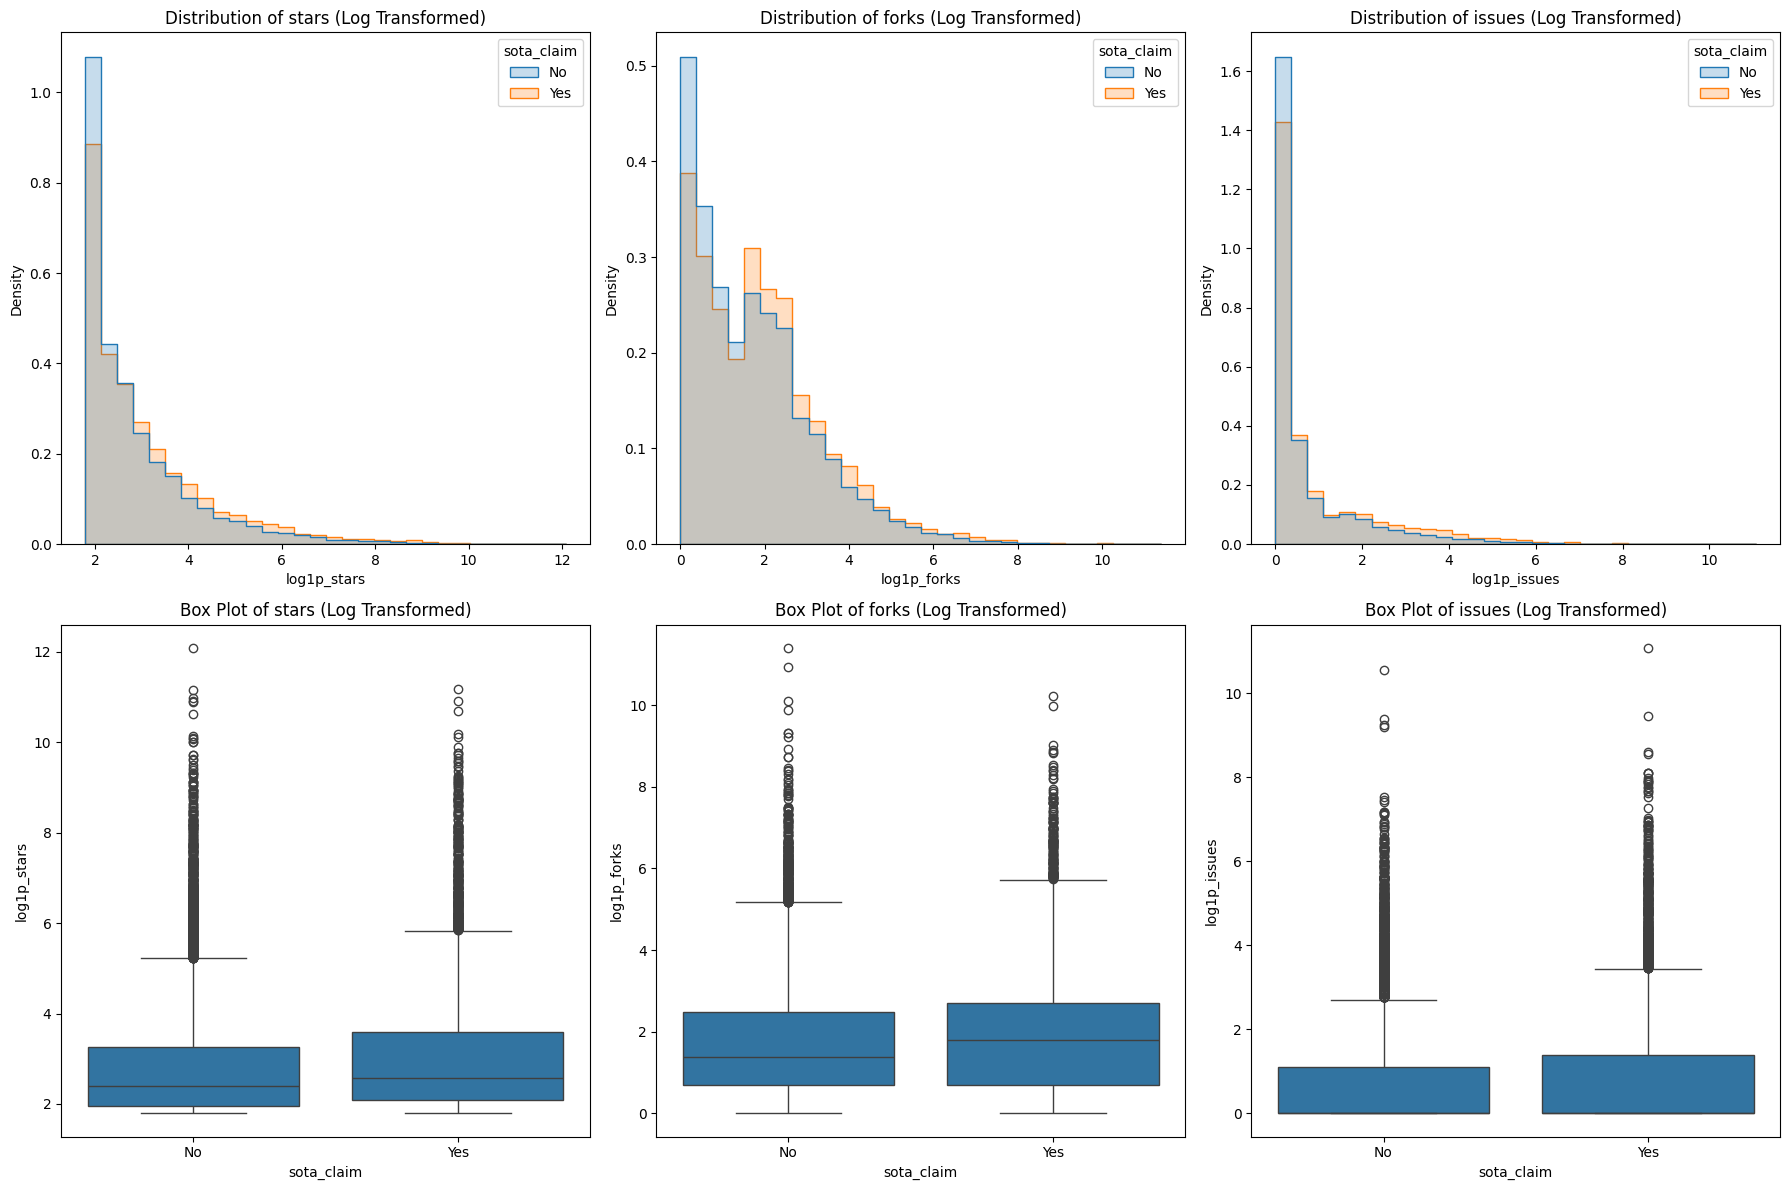

In [14]:
# Apply np.log1p transformation to the features and create new columns
df['log1p_stars'] = np.log1p(df['stars'])
df['log1p_forks'] = np.log1p(df['forks'])
df['log1p_issues'] = np.log1p(df['issues'])

# Set up the matplotlib figure
plt.figure(figsize=(18, 12))  # Large figure size for better readability

# List of transformed features to plot
features = ['log1p_stars', 'log1p_forks', 'log1p_issues']

# Loop through the features list and create a subplot for each feature
for i, feature in enumerate(features):
    # Create a subplot position for each feature
    plt.subplot(2, len(features), i + 1)
    # Plotting histogram for the feature
    sns.histplot(data=df, x=feature, hue='sota_claim', element='step', stat='density', common_norm=False, bins=30)
    plt.title(f'Distribution of {feature.replace("log1p_", "")} (Log Transformed)')

    # Create a subplot position for the box plot right below the histogram
    plt.subplot(2, len(features), len(features) + i + 1)
    # Plotting box plot for the feature
    sns.boxplot(x='sota_claim', y=feature, data=df)
    plt.title(f'Box Plot of {feature.replace("log1p_", "")} (Log Transformed)')

plt.tight_layout()
plt.show()


## Pearson's Correlation Coefficient

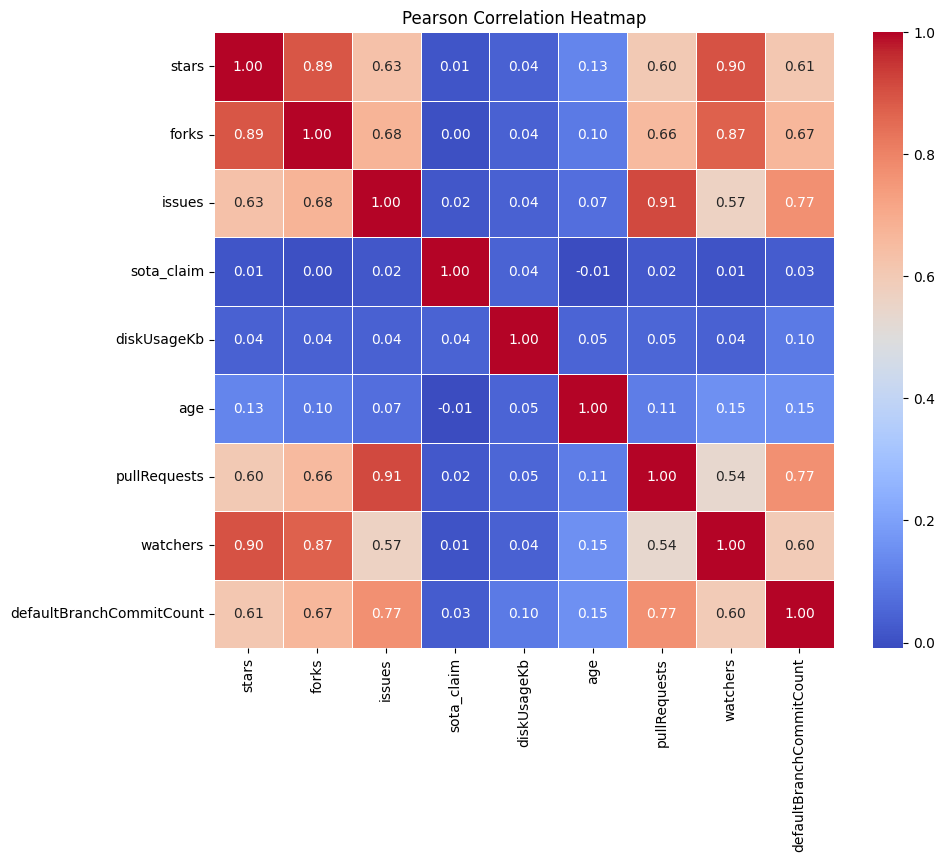

In [15]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))  # Adjust figure size for the heatmap

# List of features to plot including 'sota_claim'
features = ['stars', 'forks', 'issues', 'sota_claim', 'diskUsageKb', 'age',\
           'pullRequests', 'watchers', 'defaultBranchCommitCount']

# Selecting the relevant columns for correlation calculation
selected_data = df_ohe[features]

# Calculating Pearson's correlation coefficients
correlation_matrix = selected_data.corr()

# Generating a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation Heatmap')
plt.show()

### Data-set splitting: input and target

In [15]:
df_ohe.columns

Index(['owner', 'name', 'stars', 'forks', 'watchers', 'description',
       'diskUsageKb', 'pullRequests', 'issues', 'defaultBranchCommitCount',
       'age', 'max_similarity', 'sota_claim', 'primaryLanguage_C',
       'primaryLanguage_C++', 'primaryLanguage_HTML', 'primaryLanguage_Java',
       'primaryLanguage_JavaScript', 'primaryLanguage_Jupyter Notebook',
       'primaryLanguage_Other', 'primaryLanguage_Python',
       'primaryLanguage_TeX', 'primaryLanguage_TypeScript'],
      dtype='object')

## Robust Test Framework

In [12]:
# Filtering and dropping unwanted columns
columns_to_exclude = ['owner', 'description', 'max_similarity', 'primaryLanguage_Other',\
                     'sota_claim', 'name']
X = df_ohe.loc[df_ohe['age'] >= 0].drop(columns=columns_to_exclude)
y = df_ohe.loc[df_ohe['age'] >= 0]['sota_claim']

In [13]:
count_sota_claim = (df_ohe['sota_claim'] == 1).sum()
print(count_sota_claim)

6700


In [14]:
count_sota_claim = (df_ohe['sota_claim'] == 0).sum()
print(count_sota_claim)

13011


### Function Definition

In [15]:
def model_evaluation_framework(model, X, y, seeds, test_size=0.2, model_type='logistic', pdf_path='model_analysis.pdf'):
    results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'feature_importances': []
    }

    feature_names = X.columns.tolist()  # Assuming X is a DataFrame
    all_shap_values = []

    with PdfPages(pdf_path) as pdf:
        for seed in tqdm(seeds):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Collecting metrics
            results['accuracy'].append(accuracy_score(y_test, y_pred))
            results['precision'].append(precision_score(y_test, y_pred, average='macro'))
            results['recall'].append(recall_score(y_test, y_pred, average='macro'))
            results['f1'].append(f1_score(y_test, y_pred, average='macro'))

            # Feature importances if applicable
            if hasattr(model, 'feature_importances_'):
                results['feature_importances'].append(model.feature_importances_)
                
            elif hasattr(model, 'coef_'):
                results['feature_importances'].append(model.coef_[0])

            # SHAP analysis for tree-based models
            if model_type in ['decision_tree', 'xgboost', 'random_forest']:
                explainer = shap.TreeExplainer(model)
                shap_values = explainer.shap_values(X_train)
                all_shap_values.append(shap_values)

        # Calculate mean SHAP values and plot
        if all_shap_values:
            mean_shap_values = np.mean(all_shap_values, axis=0)
            fig, ax = plt.subplots()
            shap.summary_plot(mean_shap_values, X_train, plot_type="bar", show=False)
            pdf.savefig(fig)
            plt.close(fig)

        # Calculate mean and confidence intervals for metrics and feature importances
        summary = {key: {'mean': np.mean(val), '95%_CI': (np.percentile(val, 2.5), np.percentile(val, 97.5))}
                   for key, val in results.items() if val}

        # Include performance metrics and feature importance CIs in the PDF
        fig, ax = plt.subplots()
        textstr = '\n'.join([
            f'{key}: Mean={summary[key]["mean"]:.4f}, 95% CI=({summary[key]["95%_CI"][0]:.4f}, {summary[key]["95%_CI"][1]:.4f})'
            for key in ['accuracy', 'precision', 'recall', 'f1'] if key in summary
        ])
        ax.text(0.5, 0.5, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='center', horizontalalignment='center')
        ax.axis('off')
        pdf.savefig(fig)
        plt.close(fig)

        if 'feature_importances' in summary:
            # Calculate means and confidence intervals for feature importances
            feature_importance_means = np.mean(results['feature_importances'], axis=0)
            feature_importance_cis = np.percentile(results['feature_importances'], [2.5, 97.5], axis=0)

            # Error bars need to be the absolute difference above and below the mean
            error_bars = np.abs(feature_importance_cis - feature_importance_means[None, :])

            fig, ax = plt.subplots(figsize=(18, 15))
            ax.bar(feature_names, feature_importance_means, yerr=error_bars, capsize=5)
            ax.set_ylabel('Feature Importance')
            ax.set_title('Feature Importance with 95% CI')
            ax.set_xticks(range(len(feature_names)))
            ax.set_xticklabels(feature_names, rotation=90)
            pdf.savefig(fig)
            plt.close(fig)

    return summary

### Baseline

In [16]:
def evaluate_baseline(model, X, y, seeds, test_size=0.2, pdf_path='dummy_analysis.pdf'):
    results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    with PdfPages(pdf_path) as pdf:
        for seed in seeds:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Collect metrics
            results['accuracy'].append(accuracy_score(y_test, y_pred))
            results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            results['recall'].append(recall_score(y_test, y_pred, average='macro', zero_division=0))
            results['f1'].append(f1_score(y_test, y_pred, average='macro', zero_division=0))

        # Calculate mean and confidence intervals for metrics
        summary = {key: {'mean': np.mean(val), '95%_CI': (np.percentile(val, 2.5), np.percentile(val, 97.5))}
                   for key, val in results.items() if val}

        # Include performance metrics in the PDF
        fig, ax = plt.subplots()
        textstr = '\n'.join([
            f'{key}: Mean={summary[key]["mean"]:.4f}, 95% CI=({summary[key]["95%_CI"][0]:.4f}, {summary[key]["95%_CI"][1]:.4f})'
            for key in summary
        ])
        ax.text(0.5, 0.5, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='center', horizontalalignment='center')
        ax.axis('off')
        pdf.savefig(fig)
        plt.close(fig)

        # Classification report for the last seed
        report = classification_report(y_test, y_pred, output_dict=True)
        
        # Prepare data for the classification report table, filtering out non-dict items
        table_content = []
        row_labels = []
        for label, metrics in report.items():
            if isinstance(metrics, dict):  # Ensure it's a dictionary type, filtering out 'accuracy' or similar
                row_labels.append(label)
                table_content.append([f"{value:.2f}" for value in metrics.values()])

        col_labels = ["Precision", "Recall", "F1-score", "Support"]

        report_fig, report_ax = plt.subplots(figsize=(10, 5))
        report_ax.axis('off')
        report_table = report_ax.table(cellText=table_content, colLabels=col_labels, rowLabels=row_labels, loc='center')
        report_table.auto_set_font_size(False)
        report_table.set_fontsize(8)
        report_table.scale(1.0, 1.0)
        pdf.savefig(report_fig)
        plt.close(report_fig)

    return summary

In [39]:
from sklearn.dummy import DummyClassifier

# Dummy Classifier as a baseline
dummy_model = DummyClassifier(strategy='stratified', random_state=42)
seeds = np.random.randint(20, 33, 10)  # Random seeds between 20 and 32, total 10 seeds
summary = evaluate_baseline(dummy_model, X, y, seeds, pdf_path=f'[2nd-dataset]baseline_evaluation.pdf')
print(summary)

{'accuracy': {'mean': 0.5510053448714686, '95%_CI': (0.5426508017307203, 0.5556121150419954)}, 'precision': {'mean': 0.4996600748139916, '95%_CI': (0.48937232869072356, 0.5060917203457131)}, 'recall': {'mean': 0.49963044358691827, '95%_CI': (0.4892685236895078, 0.5059642695155264)}, 'f1': {'mean': 0.49959487064206076, '95%_CI': (0.48929893442529965, 0.5058965602584988)}}


### Logistic Regression

In [16]:
# Evaluate Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')
seeds = np.random.randint(20, 33, 10)
logistic_summary = model_evaluation_framework(logistic_model, X, y, seeds, model_type='logistic', pdf_path='[2nd-dataset]logistic_evaluation.pdf')
print("Logistic Regression Summary:", logistic_summary)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.68it/s]


Logistic Regression Summary: {'accuracy': {'mean': 0.37910409773479253, '95%_CI': (0.3654874013743955, 0.3912891320946806)}, 'precision': {'mean': 0.5167560686267729, '95%_CI': (0.5040791475208273, 0.5282302515590612)}, 'recall': {'mean': 0.5071008577991873, '95%_CI': (0.5015067800005124, 0.5122813305077702)}, 'f1': {'mean': 0.34213718503952384, '95%_CI': (0.3253798381283035, 0.3610434660257655)}, 'feature_importances': {'mean': 7.604868443177037e-06, '95%_CI': (-0.00024459200000406355, 0.00014838618503075946)}}


### XGBoost

In [17]:
y.value_counts()

sota_claim
0    12970
1     6673
Name: count, dtype: int64

In [18]:
# Calculate the ratio of negative class to positive class
ratio = float(y.value_counts()[0]) / y.value_counts()[1]

In [19]:
# Instantiate the model with the calculated scale_pos_weight
model = XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.8,
    random_state=42,
    objective='binary:logistic',
    eval_metric=['logloss', 'error'],
    scale_pos_weight=ratio
)

seeds = np.random.randint(20, 33, 10)
summary = model_evaluation_framework(model, X, y, seeds, model_type='xgboost', pdf_path=f'[2nd-dataset]xgb_evaluation.pdf')
print(summary)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:23<00:00, 38.38s/it]


{'accuracy': {'mean': 0.6016034614405701, '95%_CI': (0.5930262153219649, 0.6093153474166455)}, 'precision': {'mean': 0.5881864147743305, '95%_CI': (0.5762755335954918, 0.6017155296642968)}, 'recall': {'mean': 0.5976197537136659, '95%_CI': (0.5850557990067192, 0.6129992924550081)}, 'f1': {'mean': 0.5839784862798847, '95%_CI': (0.5722452072688351, 0.5955830754184391)}, 'feature_importances': {'mean': 0.05882353, '95%_CI': (0.042757462710142136, 0.13182051405310632)}}


### Random Forest

In [22]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
summary = model_evaluation_framework(model, X, y, seeds, pdf_path=f'[2nd-dataset]rf_evaluation.pdf')
print(summary)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:33<00:00, 21.39s/it]


{'accuracy': {'mean': 0.6714685670654109, '95%_CI': (0.6629740391957242, 0.6782896411300585)}, 'precision': {'mean': 0.6152351186021283, '95%_CI': (0.610336504612513, 0.622860841475829)}, 'recall': {'mean': 0.5591470598489349, '95%_CI': (0.5528825085578118, 0.5624746710733176)}, 'f1': {'mean': 0.5439344010938274, '95%_CI': (0.5326879341006655, 0.5505761906113988)}, 'feature_importances': {'mean': 0.058823529411764705, '95%_CI': (0.0033379001599843417, 0.1938928946629522)}}
